## 根据用户对类目偏好打分训练基于ALS的矩阵分解模型

根据统计的次数 + 打分规则 ==> 偏好打分数据集  ==> 基于ALS的矩阵分解模型

本节目的：为每个用户召集他最感兴趣的3个类别

In [2]:
import os
# 配置pyspark和spark driver运行时 使用的python解释器
JAVA_HOME = '/root/bigdata/jdk'
PYSPARK_PYTHON = '/miniconda2/envs/py365/bin/python'
# 当存在多个版本时，不指定很可能会导致出错
os.environ['PYSPARK_PYTHON'] = PYSPARK_PYTHON
os.environ['PYSPARK_DRIVER_PYTHON'] = PYSPARK_PYTHON
os.environ['JAVA_HOME'] = JAVA_HOME
# 配置spark信息
from pyspark import SparkConf
from pyspark.sql import SparkSession

SPARK_APP_NAME = 'createUserCateRatingALSModel'
SPARK_URL = 'spark://192.168.58.100:7077'

conf = SparkConf()    # 创建spark config对象
config = (
    ("spark.app.name", SPARK_APP_NAME),    # 设置启动的spark的app名称，没有提供，将随机产生一个名称
    ("spark.executor.memory", "2g"),    # 设置该app启动时占用的内存用量，默认1g
    ("spark.master", SPARK_URL),    # spark master的地址
    ("spark.executor.cores", "2"),    # 设置spark executor使用的CPU核心数
    # 以下三项配置，可以控制执行器数量
    # ("spark.dynamicAllocation.enabled", True),
    # ("spark.dynamicAllocation.initialExecutors", 1),    # 1个执行器
    # ("spark.shuffle.service.enabled", True)
    # ('spark.sql.pivotMaxValues', '99999'),  # 当需要pivot DF，且值很多时，需要修改，默认是10000
)
# 查看更详细配置及说明：https://spark.apache.org/docs/latest/configuration.html

conf.setAll(config)

# 利用config对象，创建spark session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [ ]:
# spark ml的模型训练是基于内存的，如果数据过大，内存空间小，迭代次数过多的化，可能会造成内存溢出，报错
# 设置Checkpoint的话，会把所有数据落盘，这样如果异常退出，下次重启后，可以接着上次的训练节点继续运行
# 但该方法其实指标不治本，因为无法防止内存溢出，所以还是会报错
# 如果数据量大，应考虑的是增加内存、或限制迭代次数和训练数据量级等
spark.sparkContext.setCheckpointDir("checkPoint")

In [4]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, FloatType
schema = StructType([
    StructField("userId", IntegerType()),
    StructField("cateId", IntegerType()),
    StructField("pv", IntegerType()),
    StructField("fav", IntegerType()),
    StructField("cart", IntegerType()),
    StructField("buy", IntegerType())
])

# 加载上一节存的透视表
# 从hdfs加载CSV文件,这种加载有一个好处：加载出的新df可以指定新的schema
# 我尝试过如果指定，pv到buy的数据类型是bigint(即longtype)，这种类型在下面toDF那步会报错，转换成int就不会
cate_count_df = spark.read.csv("cate_count.csv", header=True, schema=schema)
cate_count_df.printSchema()
cate_count_df.first() 

root
 |-- userId: integer (nullable = true)
 |-- cateId: integer (nullable = true)
 |-- pv: integer (nullable = true)
 |-- fav: integer (nullable = true)
 |-- cart: integer (nullable = true)
 |-- buy: integer (nullable = true)



Row(userId=375653, cateId=6341, pv=None, fav=None, cart=None, buy=None)

In [73]:
# 对比cate_count_df.printSchema()的效果
cate_count_df.printSchema

<bound method DataFrame.printSchema of DataFrame[userId: int, cateId: int, pv: int, fav: int, cart: int, buy: int]>

In [5]:
def process_row(r):
    # 注意这里要全部设为浮点数，spark运算时对类型比较敏感，要保持数据类型都一致
    pv_count = r.pv if r.pv else 0.0
    fav_count = r.fav if r.fav else 0.0#浏览次数
    cart_count = r.cart if r.cart else 0.0
    buy_count = r.buy if r.buy else 0.0

    # 该偏好权重比例，次数上限仅供参考，具体数值应根据产品业务场景权衡
    pv_score = 0.2*pv_count if pv_count<=20 else 4.0
    fav_score = 0.4*fav_count if fav_count<=20 else 8.0
    cart_score = 0.6*cart_count if cart_count<=20 else 12.0
    buy_score = 1*buy_count if buy_count<=20 else 20.0

    rating = pv_score + fav_score + cart_score + buy_score
    # 返回用户ID、分类ID、用户对分类的偏好打分
    return r.userId, r.cateId, rating
# toDF不是每个rdd都有的方法，DF->RDD->DF 仅限此处的 rdd
cate_rating_df =cate_count_df.rdd.map(process_row).toDF(["userId", "cateId", "rating"])

In [6]:
# cate_count_df都死int型，结果运算后变成了long和double型
cate_rating_df

DataFrame[userId: bigint, cateId: bigint, rating: double]

In [7]:
cate_rating_df.show()

+-------+------+------+
| userId|cateId|rating|
+-------+------+------+
| 375653|  6341|   0.0|
|1095337|  4290|   0.0|
| 689354|  4278|   0.0|
| 773481|  4521|   0.0|
| 279865|  4297|   0.6|
| 876505|  5510|   0.0|
| 182591|  5954|   0.6|
| 149925|  6130|   0.0|
| 799323|  6736|   0.0|
|1096923| 11156|   0.0|
|  58847|  6426|   0.0|
| 462878|  6682|   0.0|
|1012280|  5038|   0.0|
| 790875|  6244|   0.0|
| 506220|  4267|   0.0|
| 222785|  3772|   0.0|
|  95052|  6547|   0.0|
| 369186|    45|   0.0|
| 747755|  6427|   0.0|
| 196296|  7021|   0.0|
+-------+------+------+
only showing top 20 rows



In [ ]:
# 可通过该方法获得 user-cate-matrix
# 但由于cateId字段过多，这里运算量比很大，机器内存要求很高才能执行，否则无法完成任务
# 请谨慎使用

# 但好在我们训练ALS模型时，不需要转换为user-cate-matrix，所以这里可以不用运行
# cate_rating_df.groupBy("userId").povit("cateId").min("rating")

#### 通常如果使用USER-ITEM打分数据应该是通过以下方式进行处理转换为user-cate-matrix
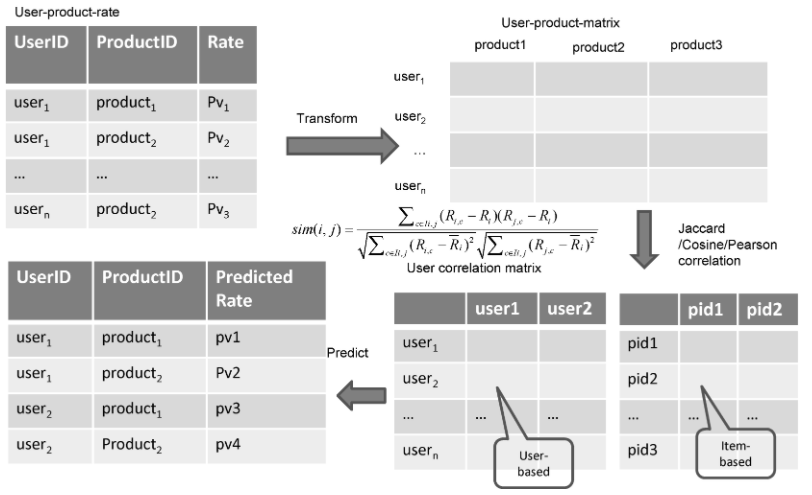
#### 但这里我们将使用Spark的ALS模型进行CF推荐，因此不需要转换矩阵

#### 基于Spark的ALS隐因子模型进行CF评分预测

ALS的意思是交替最小二乘法（Alternating Least Squares），是Spark2.*中加入的进行基于模型的协同过滤（model-based CF）的推荐系统算法。


#### 详细使用方法：[pyspark.ml.recommendation.ALS](https://spark.apache.org/docs/2.2.2/api/python/pyspark.ml.html?highlight=vectors#module-pyspark.ml.recommendation)

注意：由于数据量巨大，因此这里也不考虑基于内存的CF算法

参考：[为什么Spark中只有ALS](https://www.cnblogs.com/mooba/p/6539142.html)

In [9]:
# 使用pyspark中的ALS矩阵分解方法实现CF评分预测
# 文档地址：https://spark.apache.org/docs/2.2.2/api/python/pyspark.ml.html?highlight=vectors#module-pyspark.ml.recommendation
from pyspark.ml.recommendation import ALS
als = ALS(userCol='userId',itemCol='cateId',ratingCol='rating',checkpointInterval=5)

In [80]:
# 此处训练时间较长
model=als.fit(cate_rating_df)

#### 模型训练好后，调用方法进行使用，[具体API查看](https://spark.apache.org/docs/2.2.2/api/python/pyspark.ml.html?highlight=alsmodel#pyspark.ml.recommendation.ALSModel)

In [82]:
# model.recommendForAllUsers(N) 给所有用户推荐TOP-N个物品
ret=model.recommendForAllUsers(3)
# 由于是给所有用户进行推荐，此处运算时间也较长
ret.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   463|[[2614,3.814289],...|
|   471|[[5595,1.3937049]...|
|   496|[[5808,0.21850951...|
|   833|[[650,3.0506895],...|
|  1088|[[7777,0.5331895]...|
|  1238|[[2531,3.9033172]...|
|  1342|[[10029,3.5094855...|
|  1580|[[4783,0.3156656]...|
|  1591|[[1856,0.5038745]...|
|  1645|[[5595,0.95775396...|
|  1829|[[5731,1.4036021]...|
|  1959|[[2614,0.70558584...|
|  2142|[[867,0.9078737],...|
|  2659|[[11410,6.4133377...|
|  3794|[[2614,0.506202],...|
|  3918|[[5595,0.41725752...|
|  3997|[[5595,1.3701121]...|
|  4519|[[2614,4.4880323]...|
|  4900|[[650,2.0529048],...|
|  4935|[[9442,2.1188283]...|
+------+--------------------+
only showing top 20 rows



In [83]:
# 推荐结果存放在recommendations列中，
ret.show(truncate=False)

+------+---------------------------------------------------------+
|userId|recommendations                                          |
+------+---------------------------------------------------------+
|463   |[[2614,3.814289], [1856,3.810282], [6133,2.9419253]]     |
|471   |[[5595,1.3937049], [7777,1.2667428], [4470,1.2655703]]   |
|496   |[[5808,0.21850951], [3280,0.20912437], [6992,0.20885153]]|
|833   |[[650,3.0506895], [11991,2.5738168], [9442,2.444895]]    |
|1088  |[[7777,0.5331895], [5873,0.4836679], [1796,0.4594512]]   |
|1238  |[[2531,3.9033172], [12511,3.4017303], [3015,3.3892038]]  |
|1342  |[[10029,3.5094855], [3601,3.1661687], [3280,3.151603]]   |
|1580  |[[4783,0.3156656], [2356,0.2983618], [2531,0.296698]]    |
|1591  |[[1856,0.5038745], [2614,0.36057153], [1460,0.3232775]]  |
|1645  |[[5595,0.95775396], [9805,0.5424484], [7777,0.5372277]]  |
|1829  |[[5731,1.4036021], [12084,1.3702909], [1796,1.3409215]]  |
|1959  |[[2614,0.70558584], [3280,0.6489351], [4783,0.5592411]

In [ ]:
# model.recommendForUserSubset 给部分用户推荐TOP-N个物品

# 注意注意注意：recommendForUserSubset API，2.2.2版本中无法使用
dataset = spark.createDataFrame([[1],[2],[3]])
dataset = dataset.withColumnRenamed("_1", "userId")
ret = model.recommendForUserSubset(dataset, 3)

# 只给部分用推荐，运算时间短
ret.show()
ret.collect()    # 注意： collect会将所有数据加载到内存，慎用

In [ ]:
# transform中提供userId和cateId可以对打分 预测，利用打分结果排序后，同样可以实现TOP-N的推荐
# model.transform
# 将模型进行存储
# 已经存过，不用再存
# model.save("models/userCateRatingALSModel.obj")

In [10]:
from pyspark.ml.recommendation import ALSModel
als_model=ALSModel.load('/models/userCateRatingALSModel.obj')
# model.recommendForAllUsers(N) 给用户推荐TOP-N个物品
# 运行时间较长
result=als_model.recommendForAllUsers(3)
result.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   148|[[5607,8.091523],...|
|   463|[[1610,8.860008],...|
|   471|[[1610,13.1980295...|
|   496|[[3347,6.303711],...|
|   833|[[5607,10.028404]...|
|  1088|[[5731,6.969639],...|
|  1238|[[1610,16.75008],...|
|  1342|[[5607,9.428972],...|
|  1580|[[5579,8.038961],...|
|  1591|[[5607,11.379921]...|
|  1645|[[201,12.506715],...|
|  1829|[[1610,19.828497]...|
|  1959|[[5631,10.744259]...|
|  2122|[[5737,11.620426]...|
|  2142|[[1610,12.57279],...|
|  2366|[[1610,13.826477]...|
|  2659|[[1610,14.002829]...|
|  2866|[[1610,11.263525]...|
|  3175|[[11568,1.8160022...|
|  3749|[[1610,3.5862575]...|
+------+--------------------+
only showing top 20 rows



In [90]:
result

DataFrame[userId: int, recommendations: array<struct<cateId:int,rating:float>>]

In [17]:
import redis
host = "192.168.58.100"
port = 6379
db = "2"
# 召回到redis
def recall_cate_by_cf(partition):
    # 建立redis 连接池
    pool = redis.ConnectionPool(host=host, port=port, db=db)
    # 建立redis客户端
    client = redis.Redis(connection_pool=pool)
    for row in partition:
        client.hset("recall_cate", row.userId, [i.cateId for i in row.recommendations])

# 对每个分片的数据进行处理
# foreachPartition()方法：将f函数应用于此DataFrame的每个分区，这是``df.rdd.foreachPartition（）``的简写。
result.foreachPartition(recall_cate_by_cf)

# 注意：这里这是召回的是用户最感兴趣的n个类别
# 存储了大半后可能报错，网上说是redis版本太高导致

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 25.0 failed 4 times, most recent failure: Lost task 0.3 in stage 25.0 (TID 365, 192.168.58.110, executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/root/bigdata/spark/python/lib/pyspark.zip/pyspark/worker.py", line 178, in main
    process()
  File "/root/bigdata/spark/python/lib/pyspark.zip/pyspark/worker.py", line 173, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/pyspark-2.2.2-py3.6.egg/pyspark/rdd.py", line 2430, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/pyspark-2.2.2-py3.6.egg/pyspark/rdd.py", line 2430, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/pyspark-2.2.2-py3.6.egg/pyspark/rdd.py", line 2430, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/pyspark-2.2.2-py3.6.egg/pyspark/rdd.py", line 353, in func
    return f(iterator)
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/pyspark-2.2.2-py3.6.egg/pyspark/rdd.py", line 801, in func
    r = f(it)
  File "<ipython-input-17-819e55a94f29>", line 12, in recall_cate_by_cf
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/redis/client.py", line 2674, in hset
    return self.execute_command('HSET', name, key, value)
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/redis/client.py", line 774, in execute_command
    connection.send_command(*args)
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/redis/connection.py", line 620, in send_command
    self.send_packed_command(self.pack_command(*args))
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/redis/connection.py", line 663, in pack_command
    for arg in imap(self.encoder.encode, args):
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/redis/connection.py", line 125, in encode
    "byte, string or number first." % typename)
redis.exceptions.DataError: Invalid input of type: 'list'. Convert to a byte, string or number first.

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:194)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:235)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:64)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:338)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1533)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1521)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1520)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1520)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1748)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1703)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1692)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2029)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2050)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2069)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2094)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:936)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:935)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:476)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/root/bigdata/spark/python/lib/pyspark.zip/pyspark/worker.py", line 178, in main
    process()
  File "/root/bigdata/spark/python/lib/pyspark.zip/pyspark/worker.py", line 173, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/pyspark-2.2.2-py3.6.egg/pyspark/rdd.py", line 2430, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/pyspark-2.2.2-py3.6.egg/pyspark/rdd.py", line 2430, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/pyspark-2.2.2-py3.6.egg/pyspark/rdd.py", line 2430, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/pyspark-2.2.2-py3.6.egg/pyspark/rdd.py", line 353, in func
    return f(iterator)
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/pyspark-2.2.2-py3.6.egg/pyspark/rdd.py", line 801, in func
    r = f(it)
  File "<ipython-input-17-819e55a94f29>", line 12, in recall_cate_by_cf
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/redis/client.py", line 2674, in hset
    return self.execute_command('HSET', name, key, value)
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/redis/client.py", line 774, in execute_command
    connection.send_command(*args)
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/redis/connection.py", line 620, in send_command
    self.send_packed_command(self.pack_command(*args))
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/redis/connection.py", line 663, in pack_command
    for arg in imap(self.encoder.encode, args):
  File "/miniconda2/envs/py365/lib/python3.6/site-packages/redis/connection.py", line 125, in encode
    "byte, string or number first." % typename)
redis.exceptions.DataError: Invalid input of type: 'list'. Convert to a byte, string or number first.

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:194)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:235)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:64)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:338)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [13]:
# 总的条目数，查看redis中总的条目数是否一致
result.count()

1136340